In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

tickers = ["SPY", "AAPL", "MSFT", "BTC-USD", "ETH-USD"]
start_date = "2022-01-01"
end_date = "2024-12-31"

os.makedirs("data", exist_ok=True)

# Download data with full structure
df = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

# Extract 'Adj Close' for all tickers
adj_close = pd.concat([df[ticker]["Adj Close"].rename(ticker) for ticker in tickers], axis=1)
adj_close.dropna(inplace=True)

# Save price data
adj_close.to_csv("data/historical_prices.csv")

# Log returns
log_returns = adj_close.pct_change().dropna().apply(lambda x: np.log1p(x))
log_returns.to_csv("data/log_returns.csv")

print("✅ Price and log return data saved.")


[*********************100%***********************]  5 of 5 completed

✅ Price and log return data saved.



 Training QGAN for SPY
  Epoch 0: D Loss = 1.5705, G Loss = 0.5152
  Epoch 100: D Loss = 1.3524, G Loss = 0.7212
  Epoch 200: D Loss = 1.3942, G Loss = 0.6890
  Epoch 300: D Loss = 1.3947, G Loss = 0.6884
  Epoch 400: D Loss = 1.3908, G Loss = 0.6907
  Epoch 500: D Loss = 1.3890, G Loss = 0.6968
  Epoch 600: D Loss = 1.4014, G Loss = 0.6830
  Epoch 700: D Loss = 1.3889, G Loss = 0.6911
  Epoch 800: D Loss = 1.3809, G Loss = 0.7064
  Epoch 900: D Loss = 1.3965, G Loss = 0.6881
 SPY Generated Mean: 0.4169, Std: 0.0029
 Saved synthetic returns: data/generated_SPY.csv


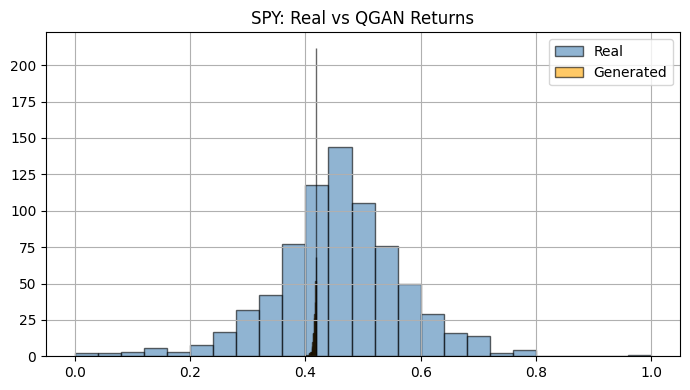


 Training QGAN for AAPL
  Epoch 0: D Loss = 1.3408, G Loss = 0.7648
  Epoch 100: D Loss = 1.3982, G Loss = 0.6718
  Epoch 200: D Loss = 1.4128, G Loss = 0.6957
  Epoch 300: D Loss = 1.1951, G Loss = 0.8191
  Epoch 400: D Loss = 1.4744, G Loss = 0.5405
  Epoch 500: D Loss = 1.4117, G Loss = 0.6909
  Epoch 600: D Loss = 1.3907, G Loss = 0.6919
  Epoch 700: D Loss = 1.4006, G Loss = 0.6819
  Epoch 800: D Loss = 1.4041, G Loss = 0.6870
  Epoch 900: D Loss = 1.3890, G Loss = 0.6901
 AAPL Generated Mean: 0.3196, Std: 0.0125
 Saved synthetic returns: data/generated_AAPL.csv


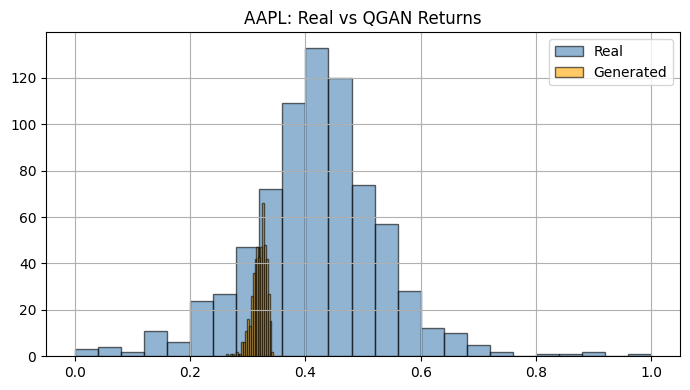


 Training QGAN for MSFT
  Epoch 0: D Loss = 1.3691, G Loss = 0.7136
  Epoch 100: D Loss = 1.4368, G Loss = 0.6400
  Epoch 200: D Loss = 1.3486, G Loss = 0.6520
  Epoch 300: D Loss = 1.4476, G Loss = 0.6691
  Epoch 400: D Loss = 1.3448, G Loss = 0.7895
  Epoch 500: D Loss = 1.3771, G Loss = 0.6432
  Epoch 600: D Loss = 1.4043, G Loss = 0.7079
  Epoch 700: D Loss = 1.4100, G Loss = 0.6706
  Epoch 800: D Loss = 1.3870, G Loss = 0.6815
  Epoch 900: D Loss = 1.3832, G Loss = 0.7400
 MSFT Generated Mean: 0.4436, Std: 0.0231
 Saved synthetic returns: data/generated_MSFT.csv


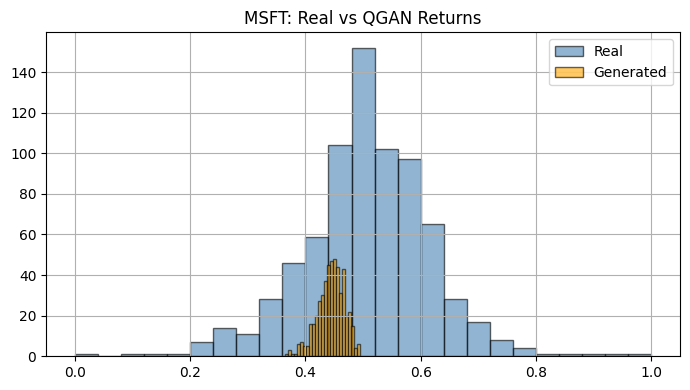


 Training QGAN for BTC-USD
  Epoch 0: D Loss = 1.3235, G Loss = 0.7394
  Epoch 100: D Loss = 1.4479, G Loss = 0.6567
  Epoch 200: D Loss = 1.3945, G Loss = 0.6634
  Epoch 300: D Loss = 1.3489, G Loss = 0.6642
  Epoch 400: D Loss = 1.4140, G Loss = 0.7116
  Epoch 500: D Loss = 1.3755, G Loss = 0.7236
  Epoch 600: D Loss = 1.3887, G Loss = 0.6736
  Epoch 700: D Loss = 1.3951, G Loss = 0.6994
  Epoch 800: D Loss = 1.3901, G Loss = 0.7156
  Epoch 900: D Loss = 1.3914, G Loss = 0.6823
 BTC-USD Generated Mean: 0.5975, Std: 0.0226
 Saved synthetic returns: data/generated_BTC-USD.csv


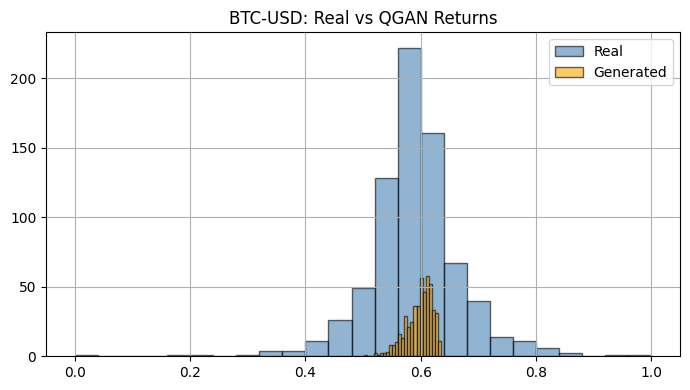


 Training QGAN for ETH-USD
  Epoch 0: D Loss = 1.3904, G Loss = 0.6385
  Epoch 100: D Loss = 1.4056, G Loss = 0.6735
  Epoch 200: D Loss = 1.3420, G Loss = 0.7447
  Epoch 300: D Loss = 1.4217, G Loss = 0.6712
  Epoch 400: D Loss = 1.3864, G Loss = 0.6953
  Epoch 500: D Loss = 1.3518, G Loss = 0.7116
  Epoch 600: D Loss = 1.3768, G Loss = 0.7209
  Epoch 700: D Loss = 1.3818, G Loss = 0.6843
  Epoch 800: D Loss = 1.3919, G Loss = 0.6900
  Epoch 900: D Loss = 1.3917, G Loss = 0.6919
 ETH-USD Generated Mean: 0.6129, Std: 0.0287
 Saved synthetic returns: data/generated_ETH-USD.csv


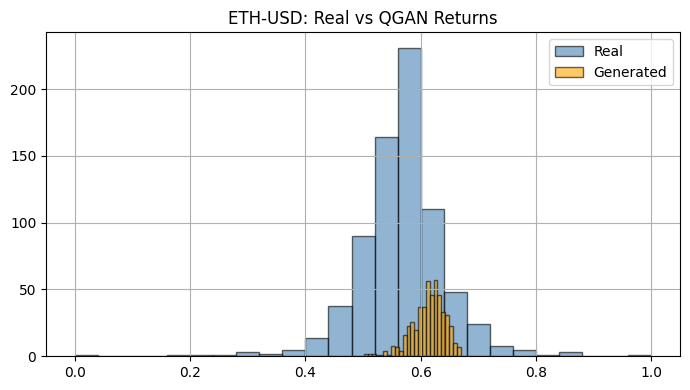

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pennylane as qml
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

# Ensure folders exist
os.makedirs("visuals", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Load log returns
log_returns = pd.read_csv("data/log_returns.csv", index_col=0)
assets = ["SPY", "AAPL", "MSFT", "BTC-USD", "ETH-USD"]

# QGAN configuration
n_qubits = 4
n_layers = 3
epochs = 1000
batch_size = 64
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit: output from 1 qubit
def generator_circuit(params):
    qml.templates.AngleEmbedding(params[0], wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(params[1], wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))  # single output

@qml.qnode(dev, interface="torch")
def quantum_generator(params):
    return generator_circuit(params)

# Generator
class QuantumGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Parameter(0.01 * torch.randn(n_qubits))
        self.entangler = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits))

    def forward(self, x=None):
        noise = 0.1 * torch.randn(n_qubits)
        emb = self.embeddings + noise
        return quantum_generator((emb, self.entangler)).unsqueeze(0)

# Discriminator
class ClassicalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Train QGAN for each asset
for asset in assets:
    print(f"\n Training QGAN for {asset}")
    real_data = log_returns[asset].dropna().values.reshape(-1, 1)
    scaler = MinMaxScaler()
    real_data = scaler.fit_transform(real_data)
    real_tensor = torch.tensor(real_data, dtype=torch.float32)

    generator = QuantumGenerator()
    discriminator = ClassicalDiscriminator()

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.003)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.003)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_batch = real_tensor[idx]

        # === Discriminator Training (every 2 epochs) ===
        if epoch % 2 == 0:
            fake_batch = torch.cat([generator() for _ in range(batch_size)]).unsqueeze(1).detach().to(torch.float32)
            fake_batch = torch.clamp(fake_batch, 0.0, 1.0)
            d_real = discriminator(real_batch)
            d_fake = discriminator(fake_batch)
            d_loss = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        # === Generator Training (every epoch) ===
        fake_batch = torch.cat([generator() for _ in range(batch_size)]).unsqueeze(1).to(torch.float32)
        fake_batch = torch.clamp(fake_batch, 0.0, 1.0)
        d_fake = discriminator(fake_batch)
        g_loss = loss_fn(d_fake, torch.ones_like(d_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: D Loss = {d_loss.item():.4f}, G Loss = {g_loss.item():.4f}")

    # Final generation
    samples = torch.cat([generator() for _ in range(500)]).unsqueeze(1).detach().to(torch.float32).numpy()
    print(f" {asset} Generated Mean: {samples.mean():.4f}, Std: {samples.std():.4f}")
    samples = scaler.inverse_transform(samples)

    # Save generated returns
    np.savetxt(f"data/generated_{asset}.csv", samples, delimiter=",")
    print(f" Saved synthetic returns: data/generated_{asset}.csv")

    # Plot and show histogram
    plt.figure(figsize=(7, 4))
    plt.hist(real_data, bins=25, alpha=0.6, label="Real", color="steelblue", edgecolor='black')
    plt.hist(scaler.transform(samples), bins=25, alpha=0.6, label="Generated", color="orange", edgecolor='black')
    plt.title(f"{asset}: Real vs QGAN Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"visuals/qgan_{asset}_hist.png")
    plt.show()


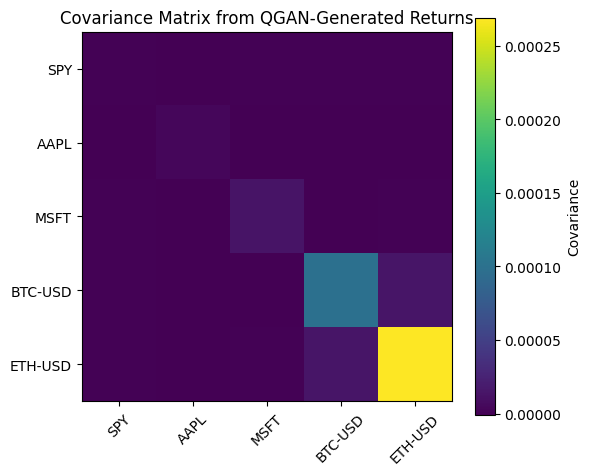

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Asset symbols (must match file names)
assets = ["SPY", "AAPL", "MSFT", "BTC-USD", "ETH-USD"]
returns = []

# Load generated returns for each asset
for asset in assets:
    data = np.loadtxt(f"data/generated_{asset}.csv", delimiter=",")
    returns.append(data.flatten())

# Convert to matrix (samples x assets)
returns_matrix = np.stack(returns, axis=1)

# Compute empirical covariance matrix from synthetic returns
cov_matrix = np.cov(returns_matrix.T)

# Plot it
plt.figure(figsize=(6, 5))
plt.imshow(cov_matrix, cmap="viridis")
plt.title("Covariance Matrix from QGAN-Generated Returns")
plt.colorbar(label="Covariance")
plt.xticks(range(len(assets)), assets, rotation=45)
plt.yticks(range(len(assets)), assets)
plt.tight_layout()
plt.show()

# Save for VQE usage
np.save("data/cov_matrix.npy", cov_matrix)


In [19]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
import numpy as np

# Load covariance matrix
cov = np.load("data/cov_matrix.npy")
n_assets = cov.shape[0]

# Binary weights for simplicity (0 or 1 for each asset)
# Hamiltonian: H = Σ Σ w_i w_j Cov_ij = w^T C w
obs = []
coeffs = []

for i in range(n_assets):
    for j in range(n_assets):
        if i == j:
            coeffs.append(cov[i, j])
            obs.append(qml.PauliZ(i))
        else:
            coeffs.append(0.5 * cov[i, j])
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

hamiltonian = qml.Hamiltonian(coeffs, obs)

# Define VQE
dev = qml.device("default.qubit", wires=n_assets)

def ansatz(params, **kwargs):
    for i in range(n_assets):
        qml.RY(params[i], wires=i)
    for i in range(n_assets - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(hamiltonian)

def cost_fn(params):
    return circuit(params)

# Optimize
opt = NesterovMomentumOptimizer(stepsize=0.4)
params = 0.01 * pnp.random.randn(n_assets)

steps = 100
for i in range(steps):
    params = opt.step(cost_fn, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost_fn(params):.6f}")

# Final weights (continuous encoding as sin^2 of RY angles)
final_weights = np.sin(params)**2
final_weights /= final_weights.sum()  # Normalize to sum to 1

# Show results
print("\n Final Portfolio Weights (Normalized):")
for i, w in enumerate(final_weights):
    print(f"{assets[i]}: {w:.4f}")

# Save for plotting or downstream tasks
np.save("data/vqe_weights.npy", final_weights)


Step 0: Cost = 0.000398
Step 10: Cost = 0.000398
Step 20: Cost = 0.000398
Step 30: Cost = 0.000398
Step 40: Cost = 0.000398
Step 50: Cost = 0.000398
Step 60: Cost = 0.000398
Step 70: Cost = 0.000398
Step 80: Cost = 0.000398
Step 90: Cost = 0.000398

 Final Portfolio Weights (Normalized):
SPY: 0.1119
AAPL: 0.6641
MSFT: 0.1729
BTC-USD: 0.0402
ETH-USD: 0.0110


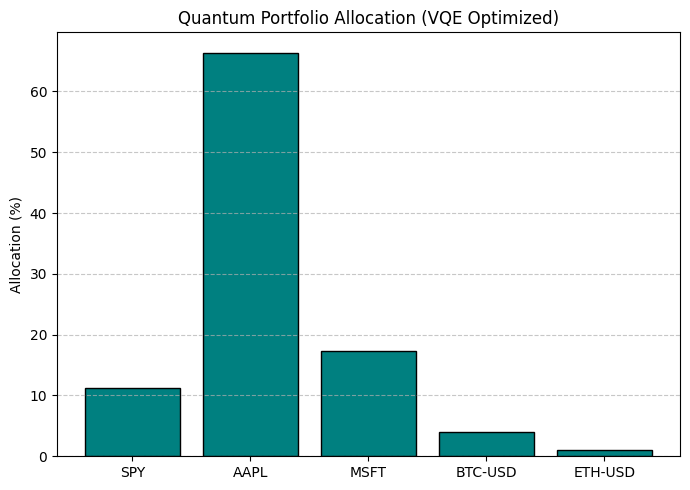

In [20]:
import matplotlib.pyplot as plt

assets = ["SPY", "AAPL", "MSFT", "BTC-USD", "ETH-USD"]
weights = np.load("data/vqe_weights.npy")

plt.figure(figsize=(7, 5))
plt.bar(assets, weights * 100, color="teal", edgecolor="black")
plt.ylabel("Allocation (%)")
plt.title("Quantum Portfolio Allocation (VQE Optimized)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


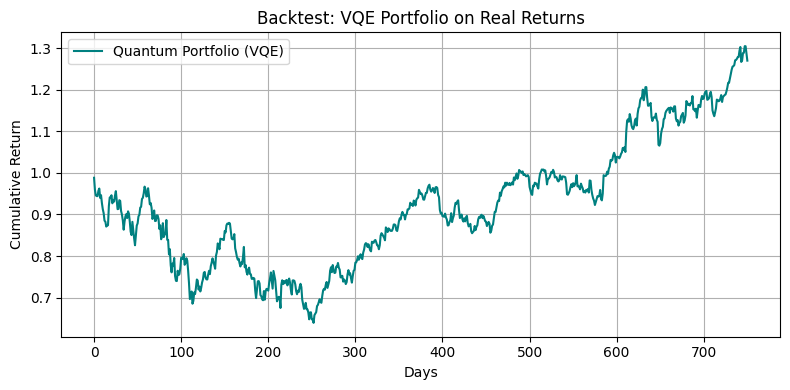

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load actual log returns and weights
real_returns = pd.read_csv("data/log_returns.csv", index_col=0)[assets].dropna()
qnn_weights = np.load("data/vqe_weights.npy")

# Quantum portfolio daily returns
portfolio_returns = real_returns.values @ qnn_weights
cumulative_returns = np.cumprod(1 + portfolio_returns)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(cumulative_returns, label="Quantum Portfolio (VQE)", color="teal")
plt.title("Backtest: VQE Portfolio on Real Returns")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


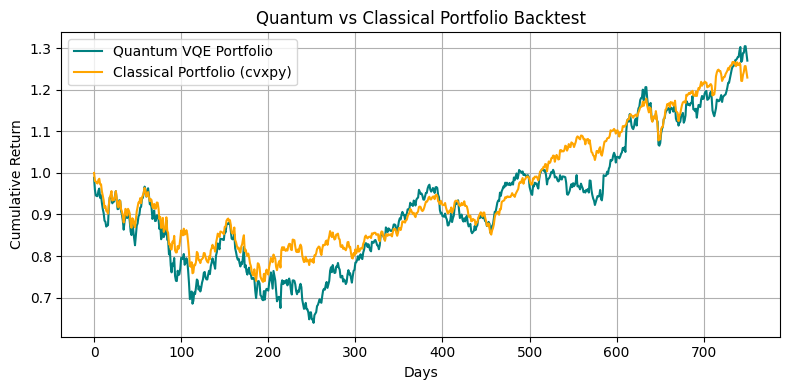

In [24]:
import cvxpy as cp

# Classical optimizer: minimize variance
Sigma = real_returns.cov().values
w = cp.Variable(len(assets))
objective = cp.Minimize(cp.quad_form(w, Sigma))
constraints = [cp.sum(w) == 1, w >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

classical_weights = w.value

# Backtest classical portfolio
classical_returns = real_returns.values @ classical_weights
cumulative_classical = np.cumprod(1 + classical_returns)

# Compare plot
plt.figure(figsize=(8, 4))
plt.plot(cumulative_returns, label="Quantum VQE Portfolio", color="teal")
plt.plot(cumulative_classical, label="Classical Portfolio (cvxpy)", color="orange")
plt.title("Quantum vs Classical Portfolio Backtest")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Save both to CSV
weights_df = pd.DataFrame({
    "Asset": assets,
    "VQE_Weight": qnn_weights,
    "Classical_Weight": classical_weights
})
weights_df.to_csv("data/portfolio_weights_comparison.csv", index=False)
print(" Saved to data/portfolio_weights_comparison.csv")


 Saved to data/portfolio_weights_comparison.csv


Sharpe Ratio (Quantum VQE): 0.028
Sharpe Ratio (Classical cvxpy): 0.030
Max Drawdown (Quantum VQE): -35.31%
Max Drawdown (Classical cvxpy): -26.19%


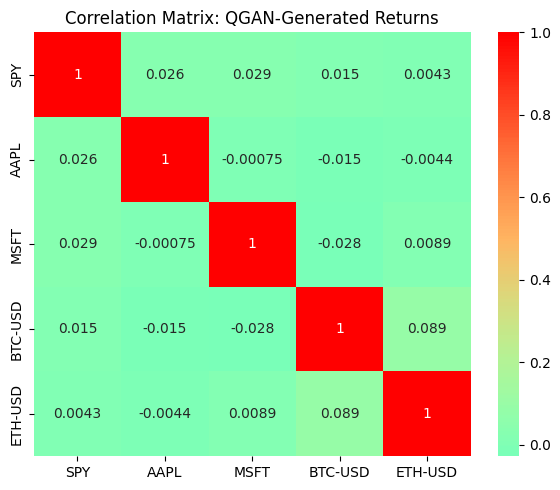

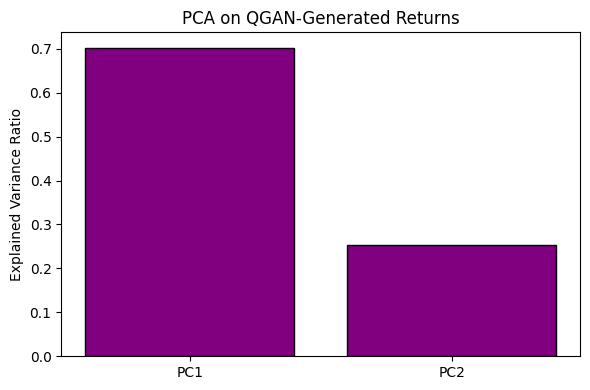

PCA Explained Variance: PC1 = 0.702, PC2 = 0.254


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load necessary data
assets = ["SPY", "AAPL", "MSFT", "BTC-USD", "ETH-USD"]
log_returns = pd.read_csv("data/log_returns.csv", index_col=0)[assets].dropna()
weights_df = pd.read_csv("data/portfolio_weights_comparison.csv")
quantum_weights = weights_df["VQE_Weight"].values
classical_weights = weights_df["Classical_Weight"].values

# Portfolio returns
qnn_returns = log_returns @ quantum_weights
classical_returns = log_returns @ classical_weights
qnn_cumulative = np.cumprod(1 + qnn_returns)
classical_cumulative = np.cumprod(1 + classical_returns)

# --- 1. Sharpe Ratio ---
def sharpe_ratio(returns, risk_free=0.0):
    excess = returns - risk_free
    return np.mean(excess) / np.std(excess)

sr_qnn = sharpe_ratio(qnn_returns)
sr_cl = sharpe_ratio(classical_returns)

print(f"Sharpe Ratio (Quantum VQE): {sr_qnn:.3f}")
print(f"Sharpe Ratio (Classical cvxpy): {sr_cl:.3f}")

# --- 2. Max Drawdown ---
def max_drawdown(cum_returns):
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return np.min(drawdown)

mdd_qnn = max_drawdown(qnn_cumulative)
mdd_cl = max_drawdown(classical_cumulative)

print(f"Max Drawdown (Quantum VQE): {mdd_qnn:.2%}")
print(f"Max Drawdown (Classical cvxpy): {mdd_cl:.2%}")

# --- 3. Correlation Matrix Heatmap of QGAN-Generated Returns ---
gen_returns = [np.loadtxt(f"data/generated_{a}.csv") for a in assets]
gen_df = pd.DataFrame(np.column_stack(gen_returns), columns=assets)

plt.figure(figsize=(6, 5))
sns.heatmap(gen_df.corr(), annot=True, cmap='rainbow', center=0)
plt.title("Correlation Matrix: QGAN-Generated Returns")
plt.tight_layout()
plt.savefig("visuals/qgan_generated_corr_heatmap.png")
plt.show()

# --- 4. PCA on QGAN-Generated Returns ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gen_df)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.bar(["PC1", "PC2"], explained_variance, color='purple', edgecolor='black')
plt.title("PCA on QGAN-Generated Returns")
plt.ylabel("Explained Variance Ratio")
plt.grid(False)
plt.tight_layout()
plt.savefig("visuals/qgan_pca_variance.png")
plt.show()

# Print explained variance
print(f"PCA Explained Variance: PC1 = {explained_variance[0]:.3f}, PC2 = {explained_variance[1]:.3f}")
